In [1]:
!hostnamectl

 Static hostname: DGX
       Icon name: computer-server
         Chassis: server 🖳
      Machine ID: dedf5691225742ff95b33f842b0781cc
         Boot ID: cb04df0ff1774eeda112c63867eeefdd
Operating System: ]8;;https://www.ubuntu.com/Ubuntu 24.04.2 LTS]8;;              
          Kernel: Linux 6.8.0-53-generic
    Architecture: x86-64
 Hardware Vendor: NVIDIA
  Hardware Model: DGXA100 920-23687-2530-002
Firmware Version: 1.29
   Firmware Date: Tue 2024-08-06
    Firmware Age: 7month 4d


- download the data
- analyze it
- make data loaders for CL
- make train function for CL
- train, test model and save metrics

## imports

In [2]:
import kagglehub
import shutil
import os
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import torch
import torchvision.models as models 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import cv2

# Data preprocessing

In [3]:
# download the data

os.chdir(os.path.expanduser("~ir739wb/ilyarekun")) # change this for your machine
print(os.system("pwd"))


dst = os.path.expanduser("bc_project/data")  

# moving data to project folder
if not os.path.exists(dst):
    os.makedirs(dst)
    print("Data dir created successfully")
    
if os.listdir(dst) == []:
    path = kagglehub.dataset_download("andyczhao/covidx-cxr2")
    print("Path to dataset files:", path)
    shutil.move(path, dst)
    print("Data moved successfully")
print(os.system("pwd"))


/home/ir739wb/ilyarekun
0
/home/ir739wb/ilyarekun
0


In [4]:
%cd bc_project/data/
data_path = ('9')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
val_data_path = os.path.join(data_path, 'val')

train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)
val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)

print(os.system('pwd'))
train_df.head()

/home/ir739wb/ilyarekun/bc_project/data
/home/ir739wb/ilyarekun/bc_project/data
0


,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [5]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df = val_df.rename(columns = {1:'image_name', 2:'diagnosis'})

In [6]:
train_df.head()


,0,image_name,diagnosis,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [7]:
train_df.tail()

,0,image_name,diagnosis,3
67858,S29624,sub-S29624_ses-E61050_run-1_bp-chest_vp-pa_dx-...,negative,bimcv
67859,S29625,sub-S29625_ses-E61052_run-1_bp-chest_vp-ap_dx-...,negative,bimcv
67860,S29626,sub-S29626_ses-E61054_run-1_bp-chest_vp-ap_dx-...,negative,bimcv
67861,S29629,sub-S29629_ses-E61058_run-1_bp-chest_vp-pa_dx-...,negative,bimcv
67862,S29630,sub-S29630_ses-E61059_run-1_bp-chest_vp-ap_dx-...,negative,bimcv


In [8]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)


In [9]:
train_df.tail()

,image_name,diagnosis
67858,sub-S29624_ses-E61050_run-1_bp-chest_vp-pa_dx-...,negative
67859,sub-S29625_ses-E61052_run-1_bp-chest_vp-ap_dx-...,negative
67860,sub-S29626_ses-E61054_run-1_bp-chest_vp-ap_dx-...,negative
67861,sub-S29629_ses-E61058_run-1_bp-chest_vp-pa_dx-...,negative
67862,sub-S29630_ses-E61059_run-1_bp-chest_vp-ap_dx-...,negative


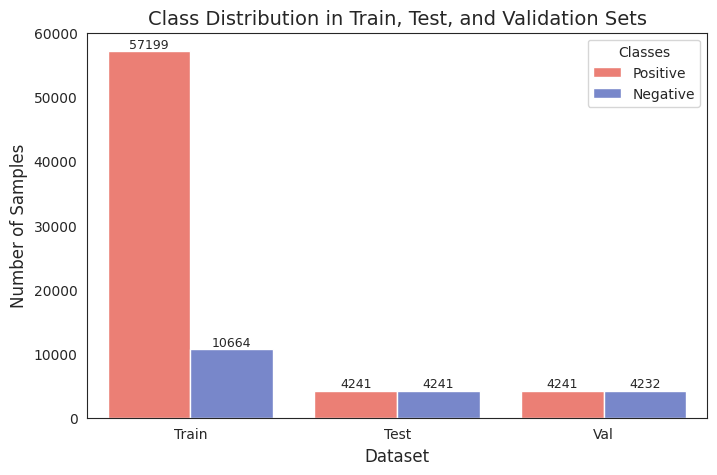

In [10]:
a,b = train_df.diagnosis.value_counts()
c,d = test_df.diagnosis.value_counts()
e,f = val_df.diagnosis.value_counts()
graph = {
    'Datasets':["Train", "Train", "Test", "Test", "Val", "Val"],
    "Classes": ["Positive", "Negative", "Positive", "Negative", "Positive", "Negative"],
    'Count' : [a,b,c,d,e,f]
}
df = pd.DataFrame(graph)
sns.set_style("white")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Datasets", y="Count", hue="Classes", data=df, palette=["#FF6F61", "#6B7FD7"])

for p in ax.containers:
    ax.bar_label(p, fmt="%.0f", fontsize=9, label_type="edge", padding=0)

plt.title("Class Distribution in Train, Test, and Validation Sets", fontsize=14)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.legend(title="Classes")
plt.show()

In [16]:
clas = np.unique(test_df.diagnosis)
clas


array(['negative', 'positive'], dtype=object)

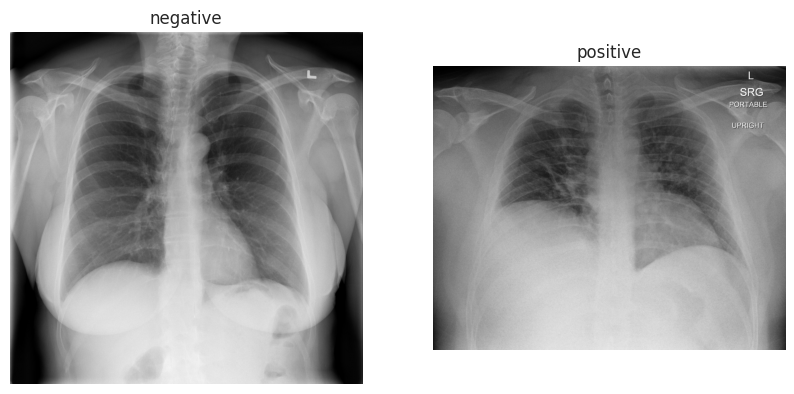

img_neg.shape (1024, 1024, 3)
img_pos.shape (826, 1024, 3)


In [21]:
neg_idx = 0
pos_idx = 0

for idx,row in test_df.iterrows():
    if row['diagnosis'] == 'negative':
        neg_idx = idx
        break
for idx,row in test_df.iterrows():
    if row['diagnosis'] == 'positive':
        pos_idx = idx
        break
        
img_neg = cv2.imread(os.path.join(test_data_path, test_df.image_name[neg_idx]))
img_pos = cv2.imread(os.path.join(test_data_path, test_df.image_name[pos_idx]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_neg/255)
plt.title(test_df.diagnosis[neg_idx])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_pos/255)
plt.title(test_df.diagnosis[pos_idx])
plt.axis('off')

plt.show()
print('img_neg.shape',img_neg.shape)
print('img_pos.shape', img_pos.shape)




In [22]:
from sklearn import cluster

kmeans = cluster.KMeans(5)
dims = np.shape(img_neg)
pixel_matrix = np.reshape(img_neg, (dims[0] * dims[1], dims[2]))
clustered = kmeans.fit_predict(pixel_matrix)

clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)
plt.title('negative')
plt.show()

: 

In [12]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

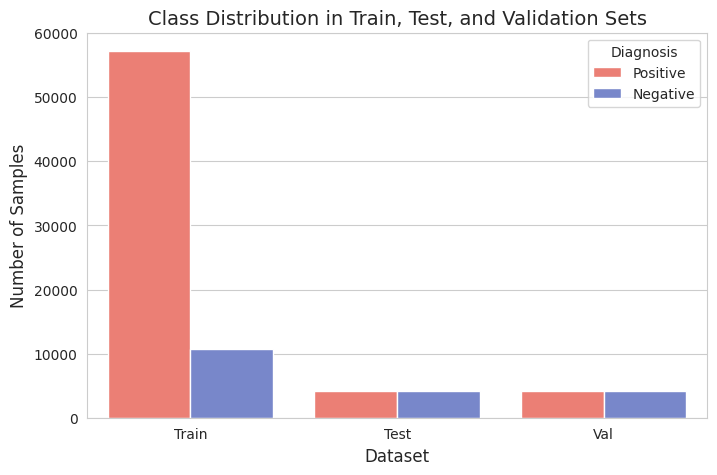

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Данные
data = {
    "Dataset": ["Train", "Train", "Test", "Test", "Val", "Val"],
    "Diagnosis": ["Positive", "Negative", "Positive", "Negative", "Positive", "Negative"],
    "Count": [57199, 10664, 4241, 4241, 4241, 4232]
}

df = pd.DataFrame(data)

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))

# График
ax = sns.barplot(x="Dataset", y="Count", hue="Diagnosis", data=df, palette=["#FF6F61", "#6B7FD7"])

# Заголовок и подписи
plt.title("Class Distribution in Train, Test, and Validation Sets", fontsize=14)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.legend(title="Diagnosis")
plt.show()


In [14]:
def data_loaders_centralyzed():
    os.chdir(os.path.expanduser("~ir739wb/ilyarekun/bc_project/01data/9"))

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Tensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
    ])
    
    train_dataset = ImageFolder('train', transform=transform)
    test_dataset = ImageFolder('test', transform=transform)
    val_dataset = ImageFolder('val', transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, val_loader

# Centralyzed Learning

In [15]:

model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False
    
num_classes = 2


# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


/home/ir739wb/miniconda3/envs/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ir739wb/miniconda3/envs/myenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ir739wb/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.6MB/s]
